### Learning, Information and Knowledge Systems Lab, SEAS, Harvard University
### Hsiang Hsu
#### hsianghsu@g.harvard.edu

# CorrNets

**Spring 2018**<br/>
**Instructors**: Professor Flavio P. Calmon

---

## Learning Principal Functions - First PIC
- https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_tensorflow.py
- https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/

## Learning Principal Functions - d PICs
- The orthogonal constraint is hard to achieve

In [69]:
import tensorflow as tf

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
import seaborn as sns; sns.set()
import pandas as pd

sns.set_style('whitegrid')

%matplotlib inline

## Load the Data

In [2]:
df_train = pd.DataFrame.from_csv('MNIST_FG_mv200_train.csv')
df_test = pd.DataFrame.from_csv('MNIST_FG_mv200_test.csv')

In [3]:
print(df_train.shape)
df_train.head()

(50000, 403)


,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
0,1.0,-14.003436,-19.226145,39.506081,-30.394463,10.804059,-6.639799,-1.177137,-40.648232,7.164187,...,549.299072,16353.979492,-5291.372070,3716.289551,7813.549805,-6868.130859,23611.246094,11726.655273,-9504.044922,5.0
1,1.0,-19.347347,-11.239742,24.734577,-35.093533,0.011207,-10.972870,-11.554278,-40.101933,-1.949793,...,538.523987,16434.730469,-5321.900391,3738.852295,7856.852051,-6910.304199,23738.123047,11786.625977,-9560.744141,0.0
2,1.0,-21.047855,-2.099021,-1.042364,-29.205357,-13.049132,21.000477,-6.819585,-5.891776,9.032482,...,541.852783,16357.279297,-5290.738770,3714.902588,7810.231445,-6873.648438,23611.296875,11727.873047,-9506.867188,4.0
3,1.0,-16.703604,-22.148125,-12.299913,-3.679024,-36.029331,-14.395399,10.233508,-10.113944,-15.000937,...,534.280396,15916.410156,-5151.256348,3618.769043,7606.764160,-6686.697754,22985.072266,11416.738281,-9255.910156,1.0
4,1.0,-12.873771,-21.545732,-2.248173,-15.211798,-20.184748,4.817051,-4.210657,-16.606562,-1.501271,...,532.586548,15738.713867,-5093.625488,3576.535400,7520.725098,-6612.291016,22729.816406,11283.847656,-9153.285156,9.0


In [4]:
print(df_test.shape)
df_test.head()

(10000, 403)


,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
0,1.0,-23.045643,5.239407,-3.803450,-22.977947,-5.004230,-14.202896,-4.563009,-9.324175,3.711933,...,551.370239,16447.998047,-5320.020508,3734.220703,7855.371094,-6909.393555,23750.726562,11789.448242,-9565.526367,7.0
1,1.0,-24.747795,-5.161464,1.923092,-13.447042,-22.852196,21.516693,8.242443,-33.979042,-5.403270,...,546.876038,16498.957031,-5338.047852,3754.031982,7884.314941,-6928.972656,23823.271484,11828.379883,-9593.390625,2.0
2,1.0,-9.723198,-18.581701,4.924995,-19.046907,-16.308771,-6.239806,7.266016,-3.747316,-13.528391,...,538.942444,16125.258789,-5214.794434,3660.786621,7703.888672,-6774.765137,23287.511719,11568.291992,-9372.570312,1.0
3,1.0,-18.816034,-8.108311,3.836857,-29.744814,-12.073897,-5.868013,-6.046334,-37.217941,-4.706858,...,543.099854,16430.076172,-5319.032227,3735.633057,7852.082031,-6902.198242,23722.789062,11780.558594,-9554.924805,0.0
4,1.0,-15.015521,7.468096,8.398328,-20.168312,-5.402646,11.710374,-2.580846,-14.951288,5.403927,...,551.448181,16355.525391,-5291.345703,3711.987793,7808.644531,-6864.256348,23614.089844,11725.723633,-9501.787109,4.0


## Parse the Data

In [50]:
d = 200

def normalizeFG(F,G):
    # Values for G
    Gs = G[:,1:]
    b_mean = Gs.mean(axis=0)
    Gs = Gs - b_mean
    corrG = Gs.transpose().dot(Gs)/Gs.shape[0]
    U,v,_ = np.linalg.svd(corrG)
    corrG_sqrt_inv = (U*(v)**(-.5)).dot(U.transpose())
    
    b_mean = np.concatenate(([0],b_mean))
    B = sp.linalg.block_diag(1,corrG_sqrt_inv)
    
    nG = (G-b_mean).dot(B)

    # values for F
    Fs = F[:,1:]
    a_mean = Fs.mean(axis=0)
    Fs = Fs - a_mean
    corrF = Fs.transpose().dot(Fs)/Fs.shape[0]
    U,v,_ = np.linalg.svd(corrF)
    corrF_sqrt_inv = (U*(v)**(-.5)).dot(U.transpose())
    

    a_mean = np.concatenate(([0],a_mean))
    A = sp.linalg.block_diag(1,corrF_sqrt_inv)
    
    nF = (F-a_mean).dot(A)
    
    # Create proper normalization
    U,s,V = np.linalg.svd(nF.transpose().dot(nG)/G.shape[0])

    return A.dot(U),a_mean,B.dot(V.transpose()),b_mean

def normalization(F, G, A, B, a, b):
    wF = (F-a).dot(A)
    wG = (G-b).dot(B)
    return wF, wG

def data_parser(df, d):
    # Raw output from F_net
    F_output = df.iloc[:, 0:d].values
    # Raw output from G_net
    G_output = df.iloc[:, d:2*d].values
    
    labels = df.iloc[:, -1].values
    
    return F_output, G_output, labels

def whiten_FG(F_train, G_train, F, G):
    A, a, B, b = normalizeFG(F_train, G_train)
    wF, wG = normalization(F, G, A, B, a, b)
    return wF, wG

F_output_train, G_output_train, train_labels = data_parser(df_train, d)
F_output_test, G_output_test, test_labels = data_parser(df_test, d)
wF_train, wG_train = whiten_FG(F_output_train, G_output_train, F_output_train, G_output_train)
wF_test, wG_test =whiten_FG(F_output_train, G_output_train, F_output_test, G_output_test)
# wF_test, wG_test =whiten_FG(F_output_test, G_output_test, F_output_test, G_output_test)

In [43]:
wF_train = wF_train[:, 1:]
wG_train = wG_train[:, 1:]
wF_test = wF_test[:, 1:]
wG_test = wG_test[:, 1:]

## PICs

Training set PICs: [  1.04513831e+01   6.11593318e-01   5.79040046e-01   5.37081095e-01
   4.40710581e-01   4.11038724e-01   3.07230620e-01   2.60500292e-01
   1.87942812e-01   1.57957079e-01   1.22278708e-01   1.20451570e-01
   1.17853314e-01   1.15569322e-01   1.14670296e-01   1.13745281e-01
   1.11751620e-01   1.10585051e-01   1.09386012e-01   1.08234094e-01
   1.08045308e-01   1.06324684e-01   1.06126008e-01   1.05523483e-01
   1.04388666e-01   1.01914463e-01   1.01734690e-01   1.00730231e-01
   9.97470784e-02   9.92176594e-02   9.87336284e-02   9.83482730e-02
   9.73134584e-02   9.56189883e-02   9.49312636e-02   9.43121782e-02
   9.31623032e-02   9.30078500e-02   9.20260807e-02   9.15377555e-02
   8.99709653e-02   8.91696976e-02   8.83532514e-02   8.78753309e-02
   8.67918156e-02   8.65513319e-02   8.63195646e-02   8.50077132e-02
   8.45173085e-02   8.35031172e-02   8.26551042e-02   8.25578315e-02
   8.13186462e-02   8.08157610e-02   7.99290029e-02   7.95686823e-02
   7.90213542e-

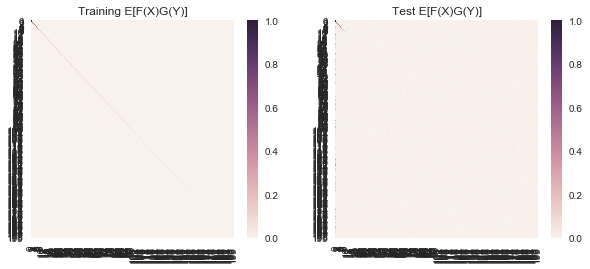

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
trueCorr_train = wF_train.transpose().dot(wG_train)/wG_train.shape[0]
sns.heatmap(trueCorr_train, vmin=0., vmax = 1., ax=ax[0])
ax[0].set_title('Training E[F(X)G(Y)]')
trueCorr_test = wF_test.transpose().dot(wG_test)/wG_test.shape[0]
sns.heatmap(trueCorr_test, vmin=0., vmax = 1., ax=ax[1])
ax[1].set_title('Test E[F(X)G(Y)]')

print('Training set PICs: {}'.format(np.diagonal(trueCorr_train)))
print('Test set PICs: {}'.format(np.diagonal(trueCorr_test)))

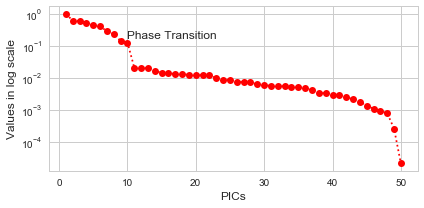

In [80]:
fs = 12
fig = plt.figure(figsize=(6, 3))
plt.semilogy(range(1, 51), np.flip(np.sort(np.abs(np.diagonal(trueCorr_test[0:50]))), 0), 'ro:')
plt.xlabel('PICs', fontsize=fs)
plt.ylabel('Values in log scale', fontsize=fs)
plt.text(9+1, trueCorr_test[9, 9]+0.05, 'Phase Transition', fontsize=fs)
# plt.title('Noisy MNIST')
plt.tight_layout()
fig.savefig('nMNIST.eps', format='eps', dpi=1000)

## Scatterplot

In [79]:
def plot_mv_PICs(F, G, d, palette, mnist_labels, description):
    F_separate = np.zeros((len(F), d))
    G_separate = np.zeros((len(G), d))
    for i in range(d):
        F_separate[:, i] = F[:, i]
        G_separate[:, i] = G[:, i]
    
    fig, ax = plt.subplots(2, 4, figsize=(40, 20))
    for i in tqdm(range(d-1)):
        F_output_temp1 = F_separate[:, i].reshape((len(F_separate), 1))
        F_output_temp2 = F_separate[:, i+1].reshape((len(F_separate), 1))
        
        G_output_temp1 = G_separate[:, i].reshape((len(G_separate), 1)) 
        G_output_temp2 = G_separate[:, i+1].reshape((len(G_separate), 1))
        for j in range(d+1):         
            F_output_draw1 = F_output_temp1[mnist_labels==j]
            F_output_draw2 = F_output_temp2[mnist_labels==j]
            G_output_draw1 = G_output_temp1[mnist_labels==j]
            G_output_draw2 = G_output_temp2[mnist_labels==j]
            
            ax[int(np.floor(i/4)), np.mod(i, 4)].scatter(F_output_draw1, F_output_draw2, alpha = 0.2, color=sns.xkcd_rgb[palette[j]], label=('Digit '+str(j)))
#             ax[int(np.floor(i/4)), np.mod(i, 4)].scatter(G_output_draw1, G_output_draw2, alpha = 0.2, color=sns.xkcd_rgb[palette[j]], label=('Digit '+str(j)))
#             ax[int(np.floor(i/4)), np.mod(i, 4)].scatter(G_output_draw1, G_output_draw2, color='black')
#             ax[int(np.floor(i/4)), np.mod(i, 4)].text(G_output_draw1[0]+0.02, G_output_draw2[0]+0.02, str(j), fontsize=15)
            ax[int(np.floor(i/4)), np.mod(i, 4)].set_xlabel('f'+str(i+1)+'(X)', fontsize=18)
            ax[int(np.floor(i/4)), np.mod(i, 4)].set_ylabel('f'+str(i+2)+'(X)', fontsize=18)
            ax[int(np.floor(i/4)), np.mod(i, 4)].legend(loc='best', fontsize=12)
#     fig.suptitle(description, fontsize=20)
#     fig.savefig(description+'.eps', format='eps', dpi=1000)
    return

100%|██████████| 8/8 [00:00<00:00, 14.49it/s]


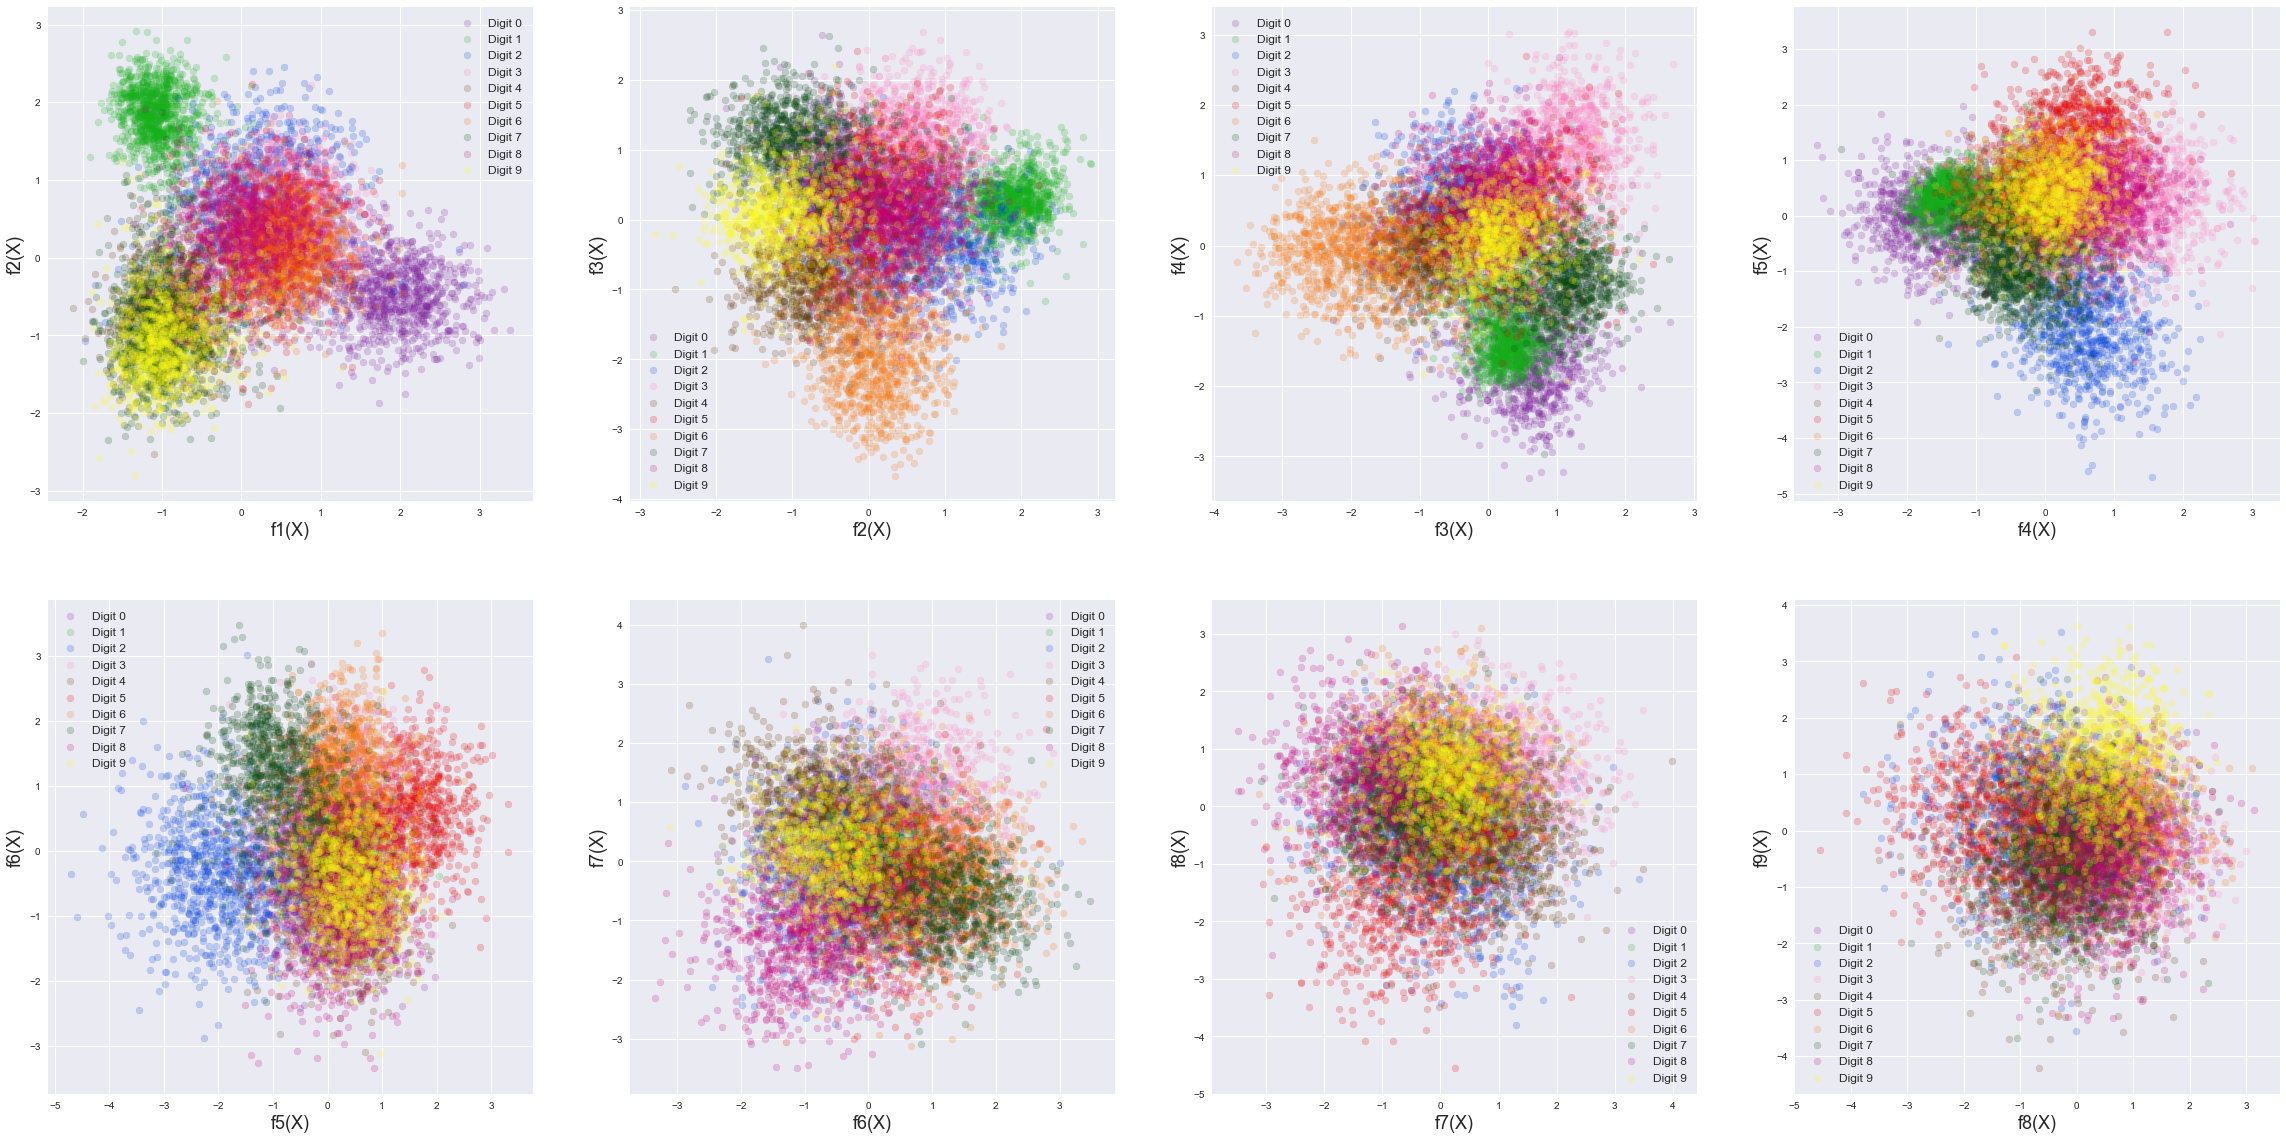

In [80]:
d = 9
palette = ['purple', 'green', 'blue', 'pink', 'brown', 'red', 'orange', 'forest green', 'magenta', 'yellow']

plot_mv_PICs(wF_test, wG_test, d, palette, test_labels, 'noisy_mnist_train')

## Spectral Clustering

In [9]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.cluster import SpectralClustering

In [10]:
from sklearn.cluster import KMeans

kcluster = KMeans(n_clusters=10, n_init=100, init='random', max_iter=10000, tol=1e-6)
cluster_test_labels = kcluster.fit_predict(wF_test[:, 0:9])

In [11]:
cnt = 0
for i in range(10):
    labels = test_labels[cluster_test_labels==i]
    l = np.argmax(np.bincount(labels.astype(int)))
    print(i, l, np.sum(labels != l), len(labels), np.sum(labels != l)/len(labels))
    cnt = cnt + np.sum(labels != l)
print('NMI = {}'.format(normalized_mutual_info_score(cluster_test_labels, test_labels)))
print('ACC = ',(1-cnt/len(test_labels))*100)

0 3 126 950 0.132631578947
1 7 105 912 0.115131578947
2 6 81 888 0.0912162162162
3 2 119 933 0.127545551983
4 5 228 959 0.237747653806
5 0 120 932 0.128755364807
6 9 287 1127 0.254658385093
7 8 234 1016 0.23031496063
8 4 286 1105 0.258823529412
9 1 83 1178 0.0704584040747
NMI = 0.6732065144195943
ACC =  83.31


In [214]:
np.isinf(wF_test[:, 0:8]).any()

False

In [41]:
sc = SpectralClustering(n_clusters=10, n_init=10, gamma = .1, n_neighbors = 5)
# cluster_test_labels = sc.fit_predict(np.hstack((wF_test[:, 0].reshape(-1, 1), wG_test[:, 0].reshape(-1, 1))))
# wG 0:5 only has 76% acc
# cluster_test_labels = sc.fit_predict(np.hstack((wF_test[:, 0:4], wG_test[:, 0:4])))
cluster_test_labels = sc.fit_predict(wF_test[:, 0:9])

In [42]:
print('NMI = {}'.format(normalized_mutual_info_score(cluster_test_labels, test_labels)))
cnt = 0
for i in range(10):
    labels = test_labels[cluster_test_labels==i]
    l = np.argmax(np.bincount(labels.astype(int)))
    print(i, l, np.sum(labels != l), len(labels))
    cnt = cnt + np.sum(labels != l)
print('ACC = ',(1-cnt/len(test_labels))*100)

NMI = 0.6545122081534377
0 4 261 1035
1 0 69 955
2 5 336 1021
3 9 300 1104
4 2 168 987
5 8 343 1095
6 3 144 946
7 7 105 880
8 6 98 874
9 1 51 1103
ACC =  81.25


In [88]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
# ebd = tsne.fit_transform(np.hstack((wF_test[:, 0:5], wG_test[:, 0:5])))
ebd = tsne.fit_transform(wF_test[:, 0:9])

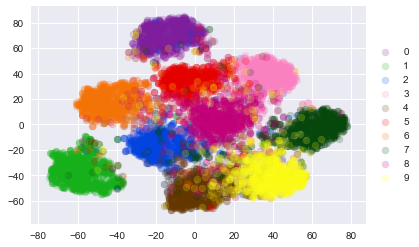

In [74]:
for i in range(10):
    ebd1 = ebd[:, 0]
    ebd2 = ebd[:, 1]
    ebd1 = ebd1[test_labels==i]
    ebd2 = ebd2[test_labels==i]
    plt.scatter(ebd1, ebd2, color=sns.xkcd_rgb[palette[i]], alpha = 0.2, label=str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, .5))

In [75]:
from sklearn.cluster import KMeans

kcluster = KMeans(n_clusters=10, n_init=100, init='random', max_iter=1000, tol=1e-5)
cluster_test_labels = kcluster.fit_predict(ebd)

In [76]:
cnt = 0
for i in range(10):
    labels = test_labels[cluster_test_labels==i]
    l = np.argmax(np.bincount(labels.astype(int)))
    print(i, l, np.sum(labels != l), len(labels), np.sum(labels != l)/len(labels))
    cnt = cnt + np.sum(labels != l)
print('NMI = {}'.format(normalized_mutual_info_score(cluster_test_labels, test_labels)))
print('ACC = ',(1-cnt/len(test_labels))*100)

0 3 141 976 0.144467213115
1 1 41 1147 0.0357454228422
2 7 79 940 0.0840425531915
3 5 166 900 0.184444444444
4 0 63 1006 0.0626242544732
5 9 219 1085 0.201843317972
6 8 268 1027 0.260954235638
7 2 152 1003 0.151545363908
8 6 94 960 0.0979166666667
9 4 166 956 0.173640167364
NMI = 0.7274155841870318
ACC =  86.11


In [14]:
kcluster = KMeans(n_clusters=10, n_init=100, init='random', max_iter=10000, tol=1e-5)
for i in range(1, 31):
    cluster_test_labels = kcluster.fit_predict(wF_test[:, 0:i])
    cnt = 0
    for i in range(10):
        labels = test_labels[cluster_test_labels==i]
        l = np.argmax(np.bincount(labels.astype(int)))
#         print(i, l, np.sum(labels != l), len(labels), np.sum(labels != l)/len(labels))
        cnt = cnt + np.sum(labels != l)
#     print('NMI = {}'.format(normalized_mutual_info_score(cluster_test_labels, test_labels)))
    print('ACC = ',(1-cnt/len(test_labels))*100)

ACC =  32.71
ACC =  48.86
ACC =  56.26
ACC =  58.93
ACC =  74.98
ACC =  80.11
ACC =  80.67
ACC =  82.51
ACC =  83.3
ACC =  83.38
ACC =  83.35
ACC =  83.24
ACC =  83.2
ACC =  83.14
ACC =  83.2
ACC =  83.13
ACC =  83.17
ACC =  83.23
ACC =  83.09
ACC =  83.07
ACC =  82.98
ACC =  83.08
ACC =  82.98
ACC =  82.97
ACC =  82.95
ACC =  82.9
ACC =  82.75
ACC =  82.64
ACC =  82.68
ACC =  82.81
